In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from IPython.display import HTML

import torch
from torch.utils.data import Dataset, dataloader
import torch.nn.functional as F
from torchsummary import summary

import sys
sys.path.append('../src')
from model import *
from Animation import AnimatedScatter, AnimatedScatter_GradientData
from datagen import DataGen

c:\Users\kingt\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data generation

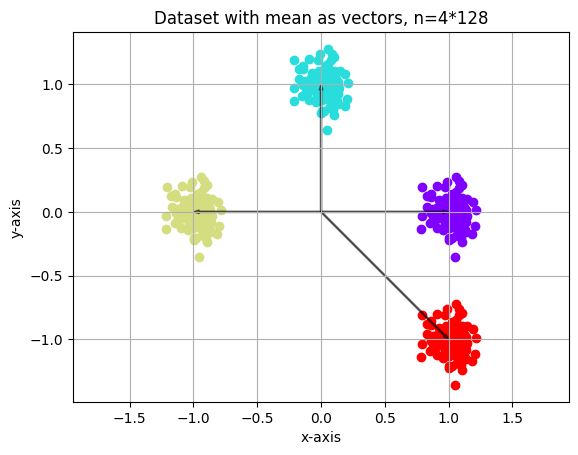

In [2]:
n_categories = 4
n_p = 128 # points_per_category


# sym, as, as_extra, parallel, manual
datatype = "as"
as_pos = np.array([1,-1])
noise = False
dataclass = DataGen(n_categories, n_p, scale=1, name=datatype, seed=1234, as_pos=as_pos,noise=noise)
centers,data,labels = dataclass.centers,dataclass.data,dataclass.labels

dataclass.plot()

if noise:
    n_categories += 1

# centers,data,labels = data_gen(n_categories,n_p,scale=1)
# centers,data,labels = data_gen_as_extra(n_categories,n_p,scale=1)

### Putting data in PyTorch dataset

In [3]:
class ScatterData(Dataset):
    def __init__(self,points,labels,n_cat):
        self.x = torch.tensor(points).float()
        self.y = torch.tensor(labels).to(int)
        self.y = F.one_hot(self.y, num_classes=n_cat).double()
    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, ix): 
        return self.x[ix], self.y[ix]

In [4]:
BATCH_SIZE = 32

training_data = ScatterData(data,labels,n_categories)
training_loader = torch.utils.data.DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

### Create model

In [5]:
# model = UMI_L1(2,n_categories,lr=1e-3)
# model = UMI(2,n_categories,lr=0.01,bias=False)


# model = UMI_J2(2,n_categories,lr=0.01,bias=False,decay=0.01)
# model = UMI_SVB_soft(2,n_categories,lr=0.001,bias=False,decay=0.01)

# summary(model,input_size=(1,2))

In [6]:
# model = UMI_Jacobi_2(2,n_categories,lr=0.001,bias=False,decay=100.0,orthogonal=False)
# epoch_data, loss_data, crossloss_data, jacobiloss_data, area_data, area_data_mD = model.train(training_loader,n_epochs=500,area=True)

In [7]:
model = UMI_Jacobi_2_savegrad(2,n_categories,lr=0.001,bias=False,decay=1.0,orthogonal=False)
epoch_data, loss_data, crossloss_data, jacobiloss_data, area_data_mD, jacobigrad_data, crossgrad_data = model.train(training_loader,n_epochs=1000,area=False)

16it [00:00, 68.56it/s] [00:00<?, ?it/s]
16it [00:00, 276.60it/s][00:00<03:58,  4.20it/s]
16it [00:00, 291.68it/s]
16it [00:00, 271.91it/s][00:00<01:46,  9.33it/s]
16it [00:00, 291.69it/s]
16it [00:00, 239.44it/s][00:00<01:22, 12.03it/s]
16it [00:00, 235.92it/s]
16it [00:00, 102.84it/s][00:00<01:17, 12.73it/s]
16it [00:00, 128.30it/s]
16it [00:00, 222.83it/s][00:00<01:43,  9.61it/s]
16it [00:00, 205.68it/s]
16it [00:00, 193.29it/s] [00:01<01:34, 10.42it/s]
16it [00:00, 130.43it/s]
16it [00:00, 286.48it/s] [00:01<01:38,  9.98it/s]
16it [00:00, 314.57it/s]
16it [00:00, 302.69it/s] [00:01<01:25, 11.55it/s]
16it [00:00, 356.51it/s]
16it [00:00, 302.69it/s] [00:01<01:14, 13.17it/s]
16it [00:00, 267.38it/s]
16it [00:00, 267.38it/s] [00:01<01:09, 14.07it/s]
16it [00:00, 291.69it/s]
16it [00:00, 267.62it/s] [00:01<01:06, 14.69it/s]
16it [00:00, 341.35it/s]
16it [00:00, 308.52it/s] [00:01<01:03, 15.47it/s]
16it [00:00, 276.60it/s]
16it [00:00, 302.70it/s] [00:01<01:01, 15.93it/s]
16it [00:00, 3

Temporarily increasing learning rate by 20


16it [00:00, 334.22it/s]
16it [00:00, 297.09it/s]0 [00:37<00:22, 17.01it/s]
16it [00:00, 356.51it/s]
16it [00:00, 314.56it/s]0 [00:37<00:21, 17.45it/s]
16it [00:00, 381.98it/s]
16it [00:00, 297.09it/s]
16it [00:00, 286.48it/s]0 [00:37<00:20, 18.08it/s]
16it [00:00, 334.23it/s]
16it [00:00, 170.67it/s]0 [00:37<00:20, 18.03it/s]
16it [00:00, 302.69it/s]
16it [00:00, 315.86it/s]0 [00:37<00:22, 16.25it/s]
16it [00:00, 314.56it/s]
16it [00:00, 364.62it/s]0 [00:37<00:21, 16.86it/s]
16it [00:00, 373.10it/s]
16it [00:00, 341.34it/s]
16it [00:00, 341.34it/s]0 [00:38<00:20, 18.10it/s]
16it [00:00, 348.76it/s]
16it [00:00, 225.96it/s]0 [00:38<00:19, 18.49it/s]
16it [00:00, 356.51it/s]
16it [00:00, 334.23it/s]0 [00:38<00:20, 17.79it/s]
16it [00:00, 327.40it/s]
16it [00:00, 320.86it/s]0 [00:38<00:19, 18.14it/s]
16it [00:00, 356.53it/s]
16it [00:00, 341.34it/s]0 [00:38<00:19, 18.50it/s]
16it [00:00, 327.41it/s]
16it [00:00, 297.09it/s]0 [00:38<00:18, 18.72it/s]
16it [00:00, 327.41it/s]
16it [00:00, 

Temporarily increasing learning rate by 20


16it [00:00, 314.58it/s]
16it [00:00, 341.34it/s]0 [00:40<00:18, 17.56it/s]
16it [00:00, 356.51it/s]
16it [00:00, 356.51it/s]
16it [00:00, 281.45it/s]0 [00:40<00:17, 18.55it/s]
16it [00:00, 341.35it/s]
16it [00:00, 356.51it/s]0 [00:40<00:17, 18.41it/s]
16it [00:00, 341.35it/s]
16it [00:00, 149.93it/s]0 [00:40<00:16, 18.79it/s]
16it [00:00, 327.41it/s]
16it [00:00, 308.52it/s]0 [00:40<00:19, 16.34it/s]
16it [00:00, 308.52it/s]
16it [00:00, 314.57it/s]0 [00:41<00:18, 16.68it/s]
16it [00:00, 334.23it/s]
16it [00:00, 348.76it/s]0 [00:41<00:18, 17.28it/s]
16it [00:00, 271.91it/s]
16it [00:00, 258.76it/s]0 [00:41<00:17, 17.46it/s]
16it [00:00, 297.10it/s]
16it [00:00, 327.41it/s]0 [00:41<00:18, 17.06it/s]
16it [00:00, 334.23it/s]
16it [00:00, 320.86it/s]0 [00:41<00:17, 17.62it/s]
16it [00:00, 329.37it/s]
16it [00:00, 352.52it/s]0 [00:41<00:16, 17.90it/s]
16it [00:00, 348.76it/s]
16it [00:00, 341.34it/s]
16it [00:00, 165.39it/s]0 [00:41<00:16, 18.75it/s]
16it [00:00, 334.24it/s]
16it [00:00, 

Temporarily increasing learning rate by 20


16it [00:00, 286.48it/s]
16it [00:00, 341.34it/s]0 [00:46<00:12, 17.29it/s]
16it [00:00, 364.61it/s]
16it [00:00, 356.51it/s]
16it [00:00, 320.86it/s]0 [00:46<00:11, 18.45it/s]
16it [00:00, 341.33it/s]
16it [00:00, 320.86it/s]0 [00:46<00:11, 18.62it/s]
16it [00:00, 327.41it/s]
16it [00:00, 348.76it/s]0 [00:46<00:11, 18.66it/s]
16it [00:00, 145.84it/s]
16it [00:00, 281.46it/s]0 [00:47<00:13, 16.22it/s]
16it [00:00, 308.52it/s]
16it [00:00, 320.85it/s]0 [00:47<00:12, 16.48it/s]
16it [00:00, 324.05it/s]
16it [00:00, 302.69it/s]0 [00:47<00:12, 17.06it/s]
16it [00:00, 314.56it/s]
16it [00:00, 311.48it/s]0 [00:47<00:11, 17.26it/s]
16it [00:00, 341.34it/s]
16it [00:00, 336.34it/s]0 [00:47<00:11, 17.69it/s]
16it [00:00, 286.48it/s]
16it [00:00, 327.40it/s]0 [00:47<00:11, 17.82it/s]
16it [00:00, 320.86it/s]
16it [00:00, 281.48it/s]0 [00:47<00:11, 18.13it/s]
16it [00:00, 267.38it/s]
16it [00:00, 308.52it/s]0 [00:47<00:11, 17.45it/s]
16it [00:00, 327.41it/s]
16it [00:00, 178.25it/s]0 [00:47<00:11

Temporarily increasing learning rate by 20


16it [00:00, 320.86it/s]
16it [00:00, 341.34it/s]
16it [00:00, 320.84it/s]0 [00:53<00:05, 17.66it/s]
16it [00:00, 364.62it/s]
16it [00:00, 302.70it/s]0 [00:53<00:05, 18.19it/s]
16it [00:00, 317.63it/s]
16it [00:00, 320.86it/s]0 [00:53<00:05, 18.13it/s]
16it [00:00, 348.77it/s]
16it [00:00, 314.57it/s]0 [00:53<00:05, 18.46it/s]
16it [00:00, 330.74it/s]
16it [00:00, 170.67it/s]0 [00:53<00:05, 18.47it/s]
16it [00:00, 348.75it/s]
16it [00:00, 308.52it/s]0 [00:54<00:05, 16.74it/s]
16it [00:00, 314.56it/s]
16it [00:00, 334.23it/s]0 [00:54<00:05, 17.16it/s]
16it [00:00, 302.70it/s]
16it [00:00, 327.41it/s]0 [00:54<00:04, 17.60it/s]
16it [00:00, 327.41it/s]
16it [00:00, 341.34it/s]0 [00:54<00:04, 17.98it/s]
16it [00:00, 348.75it/s]
16it [00:00, 364.61it/s]0 [00:54<00:04, 18.50it/s]
16it [00:00, 314.57it/s]
16it [00:00, 291.68it/s]0 [00:54<00:04, 18.84it/s]
16it [00:00, 321.24it/s]
16it [00:00, 320.86it/s]0 [00:54<00:04, 18.45it/s]
16it [00:00, 348.76it/s]
16it [00:00, 229.18it/s]0 [00:54<00:04

Temporarily increasing learning rate by 20


16it [00:00, 286.48it/s]
100%|█████████▉| 998/1000 [00:59<00:00, 15.71it/s]

Temporarily increasing learning rate by 20


16it [00:00, 320.86it/s]


Temporarily increasing learning rate by 20


16it [00:00, 351.08it/s]
100%|██████████| 1000/1000 [00:59<00:00, 16.81it/s]


### Training

In [15]:
# epoch_data, loss_data, area_data, area_data_mD = model.train(training_loader,n_epochs=500,area=True)
# epoch_data, loss_data, crossloss_data, jacobiloss_data, area_data, area_data_mD = model.train(training_loader,n_epochs=500)

# epoch_data, loss_data, crossloss_data, jacobiloss_data = model.train(training_loader,n_epochs=500)
# epoch_data, loss_data = model.train(training_loader,n_epochs=500)

### Training results visualization

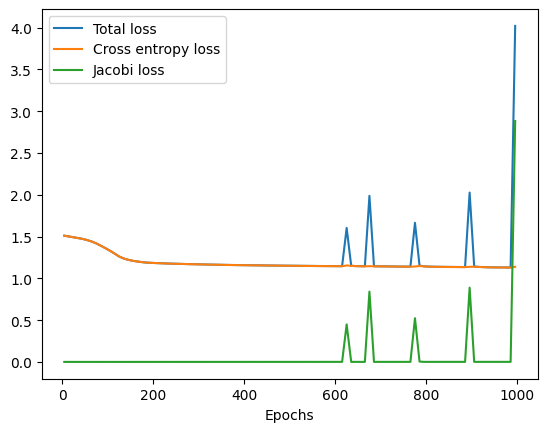

In [8]:
epoch_data_avgd = epoch_data.reshape(100,-1).mean(axis=1) # the number in reshape has to divide the number of epochs
loss_data_avgd = loss_data.reshape(100,-1).mean(axis=1)

plt.plot(epoch_data_avgd,loss_data_avgd, label="Total loss") # Plot the average loss per epoch

crossloss_data_avgd = crossloss_data[:].reshape(100,-1).mean(axis=1)
jacobiloss_data_avgd = jacobiloss_data[:].reshape(100,-1).mean(axis=1)
plt.plot(epoch_data_avgd,crossloss_data_avgd,label="Cross entropy loss") # Plot the average loss per epoch
plt.plot(epoch_data_avgd,jacobiloss_data_avgd, label="Jacobi loss") # Plot the average loss per epoch

# plt.title("Jacobi, 0.01LR, 10decay, 500 epochs, 66% acc")
# plt.plot(epoch_data,area_data, label="Weight Area")
# plt.plot(epoch_data,area_data_mD, label="Weight Area multiD")
plt.xlabel("Epochs")

# plt.plot(epoch_data,loss_data)
plt.legend()
plt.show()

### Testing

In [9]:
# t_centers, test_data, test_labels = data_gen_as_extra(n_categories,512)

test_n = 512

if noise:
    n_categories += -1

# n_categories = 2

test_data = DataGen(n_categories, test_n, scale=1, name=datatype, seed=3141, as_pos=as_pos)
t_centers, test_data, test_labels = test_data.centers,test_data.data,test_data.labels
test_set = ScatterData(test_data,test_labels,n_categories)

acc = (model(test_set.x).argmax(dim=1) == test_set.y.argmax(dim=1)).float().sum().item()/len(test_set)
print(f'Accuracy: {acc:.2f}')

Accuracy: 0.60


### Weights

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[Parameter containing:
tensor([[ 1.1464, -0.2193],
        [ 0.0677,  0.2807],
        [-1.3544,  0.3057],
        [ 1.7182, -0.5029]], requires_grad=True)]


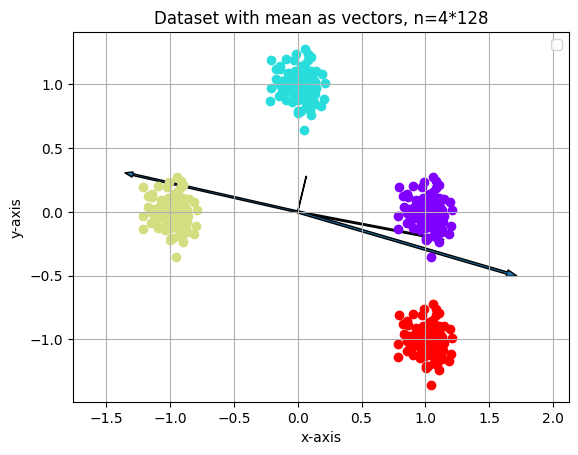

In [10]:
w = []

for param in model.parameters():
    w.append(param)
    print(w)

w_np = w[0].detach().numpy()
if len(w) > 1:
    bias = w[1].detach().numpy()



for i in range(len(w_np)):
    w_len = np.linalg.norm(w_np[i])
    width = 0.01*w_len
    # Weight arrows
    plt.arrow(0,0,w_np[i][0],w_np[i][1],length_includes_head=True,width=width)
    # Gradient arrows
    scale = 10
    # plt.arrow(w_np[i][0],w_np[i][1],scale*jacobigrad_data[-1][i][0],scale*jacobigrad_data[-1][i][1],length_includes_head=False,width=width,color=(1,0,0,0.5),label="Jacobigrad")
    # plt.arrow(w_np[i][0],w_np[i][1],scale*crossgrad_data[-1][i][0],scale*crossgrad_data[-1][i][1],length_includes_head=False,width=width,color=(0,0,1,0.5),label="Crossgrad")
    # # Sum of gradients
    # plt.arrow(w_np[i][0],w_np[i][1],scale*(jacobigrad_data[-1][i][0]+crossgrad_data[-1][i][0]),scale*(jacobigrad_data[-1][i][1]+crossgrad_data[-1][i][1]),length_includes_head=False,width=width,color=(0,1,0,0.5),label="Sum of gradients")
    # print(jacobigrad_data[-10][i]@crossgrad_data[-10][i])

colors = cm.rainbow(np.linspace(0,1,n_categories))

plt.legend()
dataclass.plot(arrows=False)
# for col,center,i in zip(colors,centers,range(n_categories)):
#     plt.scatter(data[i*n_p:(i+1)*n_p,0],data[i*n_p:(i+1)*n_p,1],color=col)
#     # plt.arrow(0,0,center[0],center[1],length_includes_head=True,width=0.01,color=(0,0,0,0.5))



# plt.grid()
# plt.axis('equal')

(1000, 2, 4)
(1000, 2, 4)


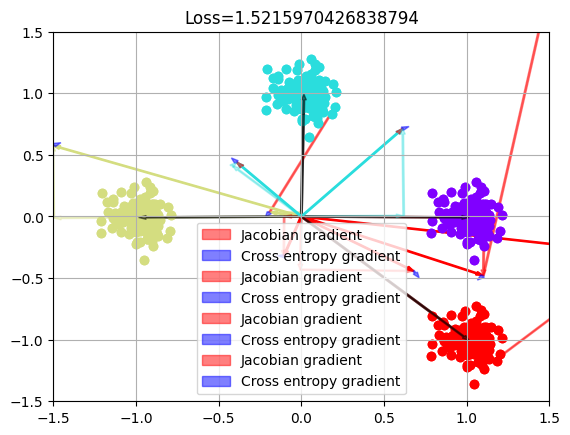

In [11]:
w_his = model.w_his
loss_data[::16].shape
w_his = np.array(w_his)
print(w_his.transpose([0,2,1]).shape)
print(jacobigrad_data.transpose([0,2,1])[::16].shape)
w_his = np.array(w_his)

# animated_scatter = AnimatedScatter(data,w_his.transpose([0,2,1]),loss_data,n_clusters=n_categories,acc=acc)
animated_scatter = AnimatedScatter_GradientData(data,w_his.transpose([0,2,1]),jacobigrad_data.transpose([0,2,1])[::16],crossgrad_data.transpose([0,2,1])[::16],loss_data,n_clusters=n_categories,acc=acc)
html_object = HTML(animated_scatter.animation.to_html5_video())
html_object